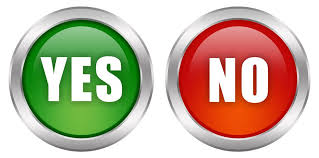

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import seaborn as sns
import nltk, re, string
from nltk import pos_tag
from nltk import word_tokenize
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
stop_words = stopwords.words('english')

from sklearn import model_selection
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC,SVC
from keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier

In [ ]:
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")

In [ ]:
print(train.shape)
train.head()

In [ ]:
print(test.shape)
test.head()

In [ ]:
print("Unique Keywords : {}, Unique locations : {}".format(len(train.keyword.unique()), len(train.location.unique())))
train.keyword.unique()

In [ ]:
print("Train : \n\n")
print(train.isnull().sum())
print("\nTest : \n\n")
print(test.isnull().sum())

In [ ]:
# Class distribution

train["target"].value_counts().plot(kind='bar')

In [ ]:
ydata = train["target"]
train = train.drop(["target","location", "id"], axis=1)

test = test.drop(["id","location"], axis=1)

In [ ]:
keyword_mapper = {}
temp = train.keyword.unique()
for i in range(len(temp)):
    keyword_mapper[temp[i]] = i
    
train["keyword"] = train["keyword"].map(keyword_mapper)
test["keyword"] = test["keyword"].map(keyword_mapper)

# Cleaning text


In [ ]:
def text_preprocessing(data):
    data = data.apply(lambda x: x.strip().lower())
    data = data.apply(lambda x: re.sub(r'\d+', '', x))
    data = data.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    
    data = data.apply(lambda x : word_tokenize(x))
    data = data.apply(lambda x: [word for word in x if word not in stop_words])
    
    
    lemmatizer = WordNetLemmatizer()
    data = data.apply(lambda x: [lemmatizer.lemmatize(word, pos ='v') for word in x])
    
    #data = data.apply(lambda x: [pos_tag(x)])
    return data


In [ ]:
test["text"] = text_preprocessing(test["text"])
train["text"] = text_preprocessing(train["text"])

# TFIDF Vectorizer

In [ ]:
vectorizer = TfidfVectorizer()
vector = vectorizer.fit_transform(["".join(i) for i in train["text"]])
vector = vector.todense()
vector = np.concatenate((vector, np.reshape(np.array(train["keyword"]), (train.keyword.shape[0],-1))), axis=1)
print(vector.shape)

# vector_test = vectorizer.fit_transform(["".join(i) for i in test["text"]])
vector_test = vectorizer.transform(["".join(i) for i in test["text"]])
vector_test = vector_test.todense()
vector_test = np.concatenate((vector_test, np.reshape(np.array(test["keyword"]), (test.keyword.shape[0],-1))), axis=1)
print(vector_test.shape)

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(vector, ydata, train_size = 0.75)

In [ ]:
svc = LinearSVC(loss="hinge",fit_intercept=False, max_iter=1500)
lr = LogisticRegression(penalty='l2')
xgb = XGBClassifier()
tree = tree = DecisionTreeClassifier(random_state = 11, max_features = "auto", class_weight = "balanced",max_depth = None)
ada = AdaBoostClassifier(base_estimator=tree)
gb = GradientBoostingClassifier(criterion='friedman_mse', learning_rate= 0.15, 
                                   loss= 'deviance', max_depth= 8, max_features='sqrt', 
                                   min_samples_leaf= 0.15714285714285714, min_samples_split= 0.5, 
                                   n_estimators= 10, subsample=1.0)
etc = ExtraTreesClassifier(bootstrap=False, criterion='gini', max_depth= None, 
                             max_features= 3, min_samples_leaf= 1, min_samples_split= 10, 
                             n_estimators= 300)

stacking_clf = StackingClassifier(estimators = [("svc",svc), ("lr",lr), ("xgb",xgb), ("d_tree",tree), ("ada",ada), ("gb",gb)
                                                ,("etc", etc)], final_estimator=LogisticRegression())

In [ ]:
cv = KFold(n_splits=10)
scores = []

for clf, label in zip([svc, lr, xgb, tree, ada, gb, etc, stacking_clf],
                     ["Support vector classifier", "Logistic regression", "XG boost", "Decision tree",
                      "Ada boost", "Gradient boosting", "Extra tree classifier"]):
        score = model_selection.cross_val_score(clf, vector, ydata, cv=cv, scoring='f1_micro')
        scores.append(score.mean())
        print("F1_score : {} (+/- {}) {}".format(score.mean(), score.std(), label))

In [ ]:
scores

# using BERT

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub

In [ ]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [ ]:
import tokenization

In [ ]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [ ]:
%%time
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
train_input = bert_encode([" ".join(i) for i in train.text], tokenizer, max_len=160)
test_input = bert_encode([" ".join(i) for i in test.text], tokenizer, max_len=160)

In [ ]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(64, activation='relu')(clf_output)
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])
    
    
    return model

In [ ]:
model = build_model(bert_layer, max_len=160)
model.summary()

In [ ]:
early = EarlyStopping(monitor='val_loss',mode='auto', baseline=None, restore_best_weights=False)
train_history = model.fit(
    train_input, ydata,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    callbacks=[early], verbose=1
)

model.save('model.h5')

In [ ]:
predictions = model.predict(test_input)
for i in [0.5, 0.6, 0.4]:
    arr = [1 if j>i else 0 for j in predictions]
    sample_sub=pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
    sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':arr})
    sub.to_csv('submission_bert'+str(i)+'.csv',index=False)